In [2]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 1.5 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 130 kB 55.9 MB/s 
     |████████████████████████████████| 151 kB 14.9 MB/s 
     |████████████████████████████████| 843 kB 11.4 MB/s 
     |████████████████████████████████| 117 kB 72.9 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=2733f78e5d55a528b2d9ab5d88dcdffb87b401762731b7d8a03446fd62d7d6a5
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=83049ec829b1a6c8c70

In [1]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 224
        record["width"] = 224
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

Mounted at /content/drive


In [8]:
classes = ['bean']

data_path = '/content/drive/MyDrive/Colab_Dataset/Vegetables/Labeled/Bean_deneme/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

AssertionError: ignored

In [9]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [10]:
output_dir = '/content/drive/MyDrive/Colab_Dataset/Vegetables/Labeled/Bean_deneme/'
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = output_dir # unutma output_dir tanımla ki model ve cfg aynı yerde olsun dikkat et!(pickle)

In [11]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[07/09 19:05:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:11, 15.3MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

In [12]:
trainer.train()

[07/09 19:05:58 d2.engine.train_loop]: Starting training from iteration 0
[07/09 19:06:06 d2.utils.events]:  eta: 0:06:06  iter: 19  total_loss: 2.101  loss_cls: 1.133  loss_box_reg: 0.1773  loss_mask: 0.6909  loss_rpn_cls: 0.07305  loss_rpn_loc: 0.03108  time: 0.3809  data_time: 0.0467  lr: 4.9953e-06  max_mem: 1863M
[07/09 19:06:13 d2.utils.events]:  eta: 0:05:49  iter: 39  total_loss: 1.927  loss_cls: 0.9641  loss_box_reg: 0.1752  loss_mask: 0.6879  loss_rpn_cls: 0.06598  loss_rpn_loc: 0.02667  time: 0.3677  data_time: 0.0065  lr: 9.9902e-06  max_mem: 1863M
[07/09 19:06:21 d2.utils.events]:  eta: 0:05:44  iter: 59  total_loss: 1.638  loss_cls: 0.681  loss_box_reg: 0.1863  loss_mask: 0.6822  loss_rpn_cls: 0.05663  loss_rpn_loc: 0.03259  time: 0.3688  data_time: 0.0108  lr: 1.4985e-05  max_mem: 1863M
[07/09 19:06:28 d2.utils.events]:  eta: 0:05:36  iter: 79  total_loss: 1.387  loss_cls: 0.4393  loss_box_reg: 0.1935  loss_mask: 0.6725  loss_rpn_cls: 0.04235  loss_rpn_loc: 0.02471  time

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

In [21]:
import pickle

cfg_save_path = "/content/drive/MyDrive/Colab_Dataset/Vegetables/Labeled/Bean_deneme/Pigment_cfg.pickle"

#save cfg for using test
with open(cfg_save_path, 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

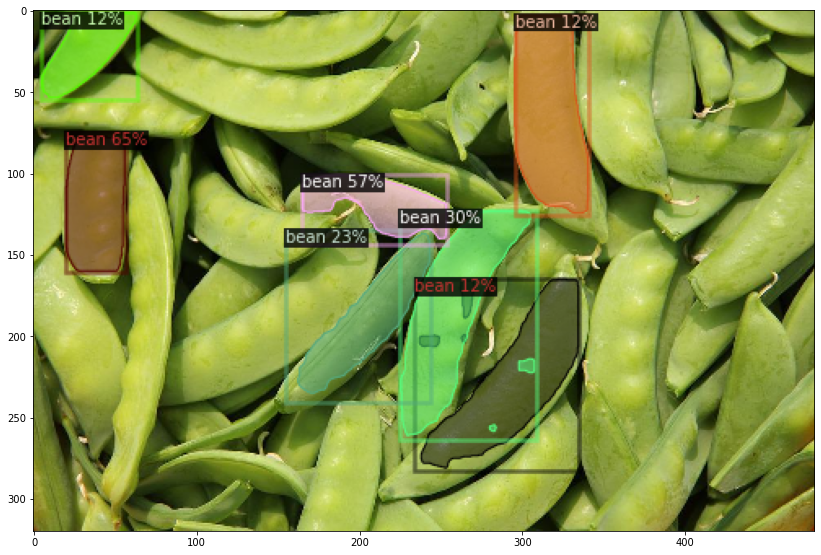

In [16]:
def on_image(image_path,predictor):
    
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], metadata=microcontroller_metadata ,scale = 0.5,instance_mode=ColorMode.SEGMENTATION)#ColorMode.IMAGE_BW ->Gray
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14,10))
    plt.imshow(v.get_image())
    plt.show()

image_path = "/content/bean_test_2.jpg"
on_image(image_path, predictor)

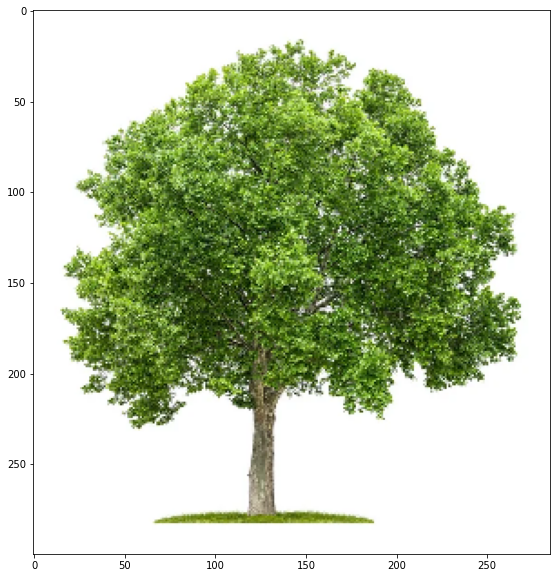

In [17]:
image_path = "/content/agac.jpg"
on_image(image_path, predictor)

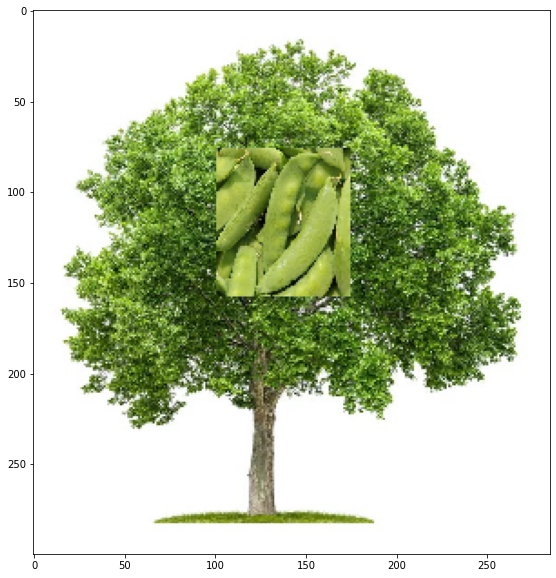

In [19]:
image_path = "/content/agac_2.jpg"
on_image(image_path, predictor)

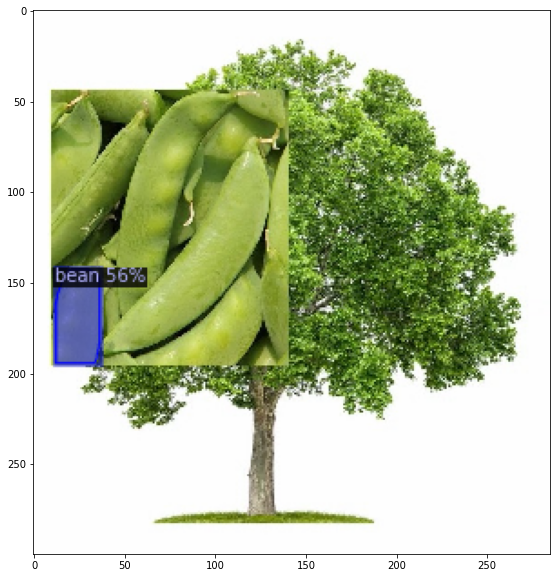

In [20]:
image_path = "/content/agac_3.jpg"
on_image(image_path, predictor)